In [ ]:
# Visualization after Lightning Pose training

# We train Lightning Pose models on Rockfish cluster to use multiple GPUs (4GPUs/node = 40 GB*4 = 160 GB).
# To visualize trainging results locally, 
# (1) Download the training outputs from Rockfish server (rockfish/.../lightning-pose-gpu/outputs) 
# to the local Lightning Pose folder (home/yiting/.../lightning-pose/outputs) 
# (2) Change data_dir, video_dir, test_videos_directory in config.yaml

# Reference: litpose_training_demo.ipynb

In [6]:
import hydra
from omegaconf import DictConfig, OmegaConf
import os
import lightning.pytorch as pl

In [7]:
# litpose_dir = r"/home/yiting/Documents/GitHub/lightning-pose"
# config_path = r"/home/yiting/Documents/LP_projects/LP_240726"
# config_name= "config_hand-6cam.yaml"
output_dir = r"/home/yiting/Documents/GitHub/lightning-pose/outputs"
model_dir = r"2026-01-01/00-01-03"
# Load hydra configuration file
cfg = OmegaConf.load(os.path.join(output_dir, model_dir, "config.yaml"))


## Predictions/diagnostics for labeled data (FiftyOne)

### Creating FiftyOne.Dataset for predictions

In [ ]:
# Override the default configs here:
cfg.eval.hydra_paths=[os.path.join(output_dir, model_dir)] # you can add multiple output_directory2, output_directory3 to compare 
cfg.eval.fiftyone.dataset_name="260102"
cfg.eval.fiftyone.model_display_names=["260102"]

In [ ]:
import fiftyone as fo
from lightning_pose.utils.fiftyone import check_dataset, FiftyOneImagePlotter

# initializes everything
fo_plotting_instance = FiftyOneImagePlotter(cfg=cfg)

# internally loops over models
dataset = fo_plotting_instance.create_dataset()

# create metadata and print if there are problems
check_dataset(dataset)
fo_plotting_instance.dataset_info_print() 

In [ ]:
# Launch the FiftyOne UI
fo.launch_app()

Dataset:     -
Session URL: http://localhost:5151/

### Launch previously created FiftyOne.Dataset objects


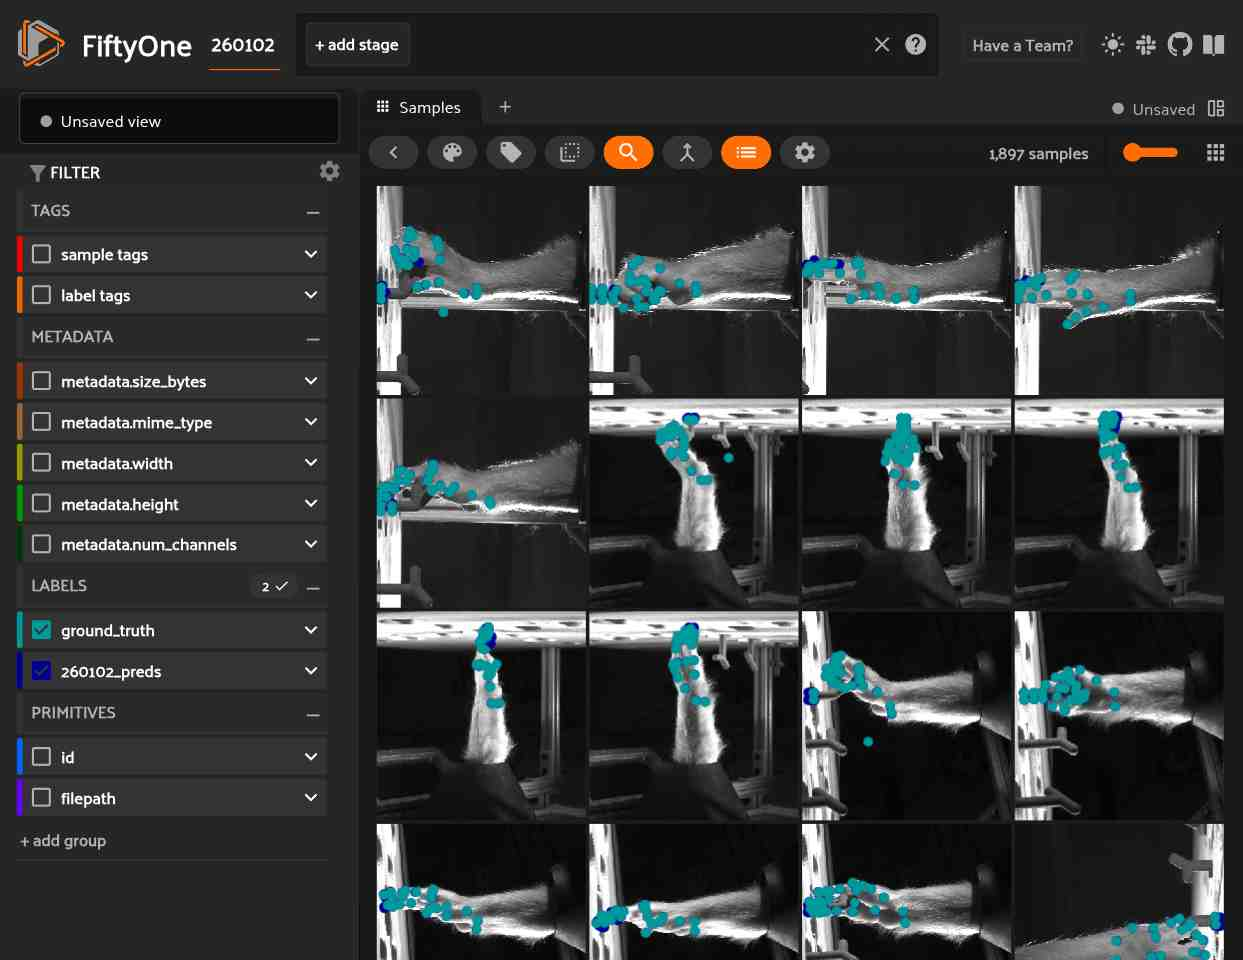

In [8]:
import fiftyone as fo
dataset = fo.load_dataset("260102")
session = fo.launch_app(dataset)

In [ ]:
# List dataset names 
fo.list_datasets()

## Plot video predictions and unsupervised losses

### Load data

In [10]:
from collections import defaultdict
import pandas as pd
from pathlib import Path

from lightning_pose.apps.utils import build_precomputed_metrics_df, get_col_names, concat_dfs
from lightning_pose.apps.utils import update_vid_metric_files_list
from lightning_pose.apps.utils import get_model_folders, get_model_folders_vis
from lightning_pose.apps.plots import plot_precomputed_traces

2026-01-12 14:54:32.859 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-12 14:54:32.860 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-12 14:54:32.860 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-12 14:54:32.861 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-12 14:54:32.862 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-12 14:54:32.862 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [12]:
# select which model(s) to use
model_folders = get_model_folders(output_dir)

# get the last two levels of each path to be presented to user
model_names = get_model_folders_vis(model_folders)

# get prediction files for each model
prediction_files = update_vid_metric_files_list(video="2025-11-20_07-58-20_camTo", model_preds_folders=model_folders)

# load data
dframes_metrics = defaultdict(dict)
dframes_traces = {}
for p, model_pred_files in enumerate(prediction_files):
    model_name = model_names[p]
    model_folder = model_folders[p]
    for model_pred_file in model_pred_files:
        model_pred_file_path = os.path.join(model_folder, "video_preds", model_pred_file)
        if not isinstance(model_pred_file, Path):
            model_pred_file.seek(0)  # reset buffer after reading
        if "pca" in str(model_pred_file) or "temporal" in str(model_pred_file) or "pixel" in str(model_pred_file):
            dframe = pd.read_csv(model_pred_file_path, index_col=None)
            dframes_metrics[model_name][str(model_pred_file)] = dframe
        else:
            dframe = pd.read_csv(model_pred_file_path, header=[1, 2], index_col=0)
            dframes_traces[model_name] = dframe
            dframes_metrics[model_name]["confidence"] = dframe
        data_types = dframe.iloc[:, -1].unique()

# compute metrics
# concat dataframes, collapsing hierarchy and making df fatter.
df_concat, keypoint_names = concat_dfs(dframes_traces)
df_metrics = build_precomputed_metrics_df(
    dframes=dframes_metrics, keypoint_names=keypoint_names)
metric_options = list(df_metrics.keys())

# print keypoint names; select one of these to plot below
print(keypoint_names)

# NOTE: you can ignore all errors and warnings of the type:
#    No runtime found, using MemoryCacheStorageManager

2026-01-12 14:59:31.417 No runtime found, using MemoryCacheStorageManager
2026-01-12 14:59:31.422 No runtime found, using MemoryCacheStorageManager
2026-01-12 14:59:31.430 No runtime found, using MemoryCacheStorageManager


['Small_Tip', 'Small_DIP', 'Small_PIP', 'Small_MCP', 'Ring_Tip', 'Ring_DIP', 'Ring_PIP', 'Ring_MCP', 'Middle_Tip', 'Middle_DIP', 'Middle_PIP', 'Middle_MCP', 'Index_Tip', 'Index_DIP', 'Index_PIP', 'Index_MCP', 'Thumb_Tip', 'Thumb_IP', 'Thumb_MCP', 'Thumb_CMC', 'Palm', 'Wrist_U', 'Wrist_R', 'Dot_t1', 'Dot_t2', 'Dot_t3', 'Dot_b1', 'Dot_b2', 'Dot_b3', 'Dot_l1', 'Dot_l2', 'Dot_l3', 'Dot_r1', 'Dot_r2', 'Dot_r3']


### Plot video traces

In [13]:
# rerun this cell each time you want to update the keypoint

from IPython.display import display, clear_output
import ipywidgets as widgets

def on_change(change):
    if change["type"] == "change" and change["name"] == "value":
        clear_output()
        cols = get_col_names(change["new"], "x", dframes_metrics.keys())
        fig_traces = plot_precomputed_traces(df_metrics, df_concat, cols)
        fig_traces.show()

# create a Dropdown widget
dropdown = widgets.Dropdown(
    options=keypoint_names,
    value=None,  # Set the default selected value
    description="Select keypoint:",
)

# update plot upon change
dropdown.observe(on_change)

# display widget
display(dropdown)

## Inference

In [ ]:
# See instruction https://lightning-pose.readthedocs.io/en/latest/source/user_guide/inference.html 
# eval.hydra_paths: path to models to use for prediction
# eval.test_videos_directory: path to a directory containing videos to run inference on
# eval.save_vids_after_training: if true, the script will also save a copy of the full video with model predictions overlaid.

In [ ]:
# Run inference on Rockfish Cluster

### Method 1: Edit config file and run


In [ ]:
# Terminal:
# python scripts/predict_new_vids.py --config-path=<PATH/TO/YOUR/CONFIGS/DIR> --config-name=<CONFIG_NAME.yaml>
#
# python scripts/predict_new_vids.py --config-path=/home/yiting/Documents/LP_projects/LP_241128 --config-name=config_hand-1cam-4gpu.yaml

### Method 2: Override these arguments in the command line


In [ ]:
# Terminal:
# python scripts/predict_new_vids.py --config-path=<PATH/TO/YOUR/CONFIGS/DIR> --config-name=<CONFIG_NAME.yaml> eval.hydra_paths=["YYYY-MM-DD/HH-MM-SS/"] eval.test_videos_directory=/absolute/path/to/videos